In [2]:
import os
import pandas as pd
import sys
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

REPO_ROOT = Path("/Users/lisawalker/Workspace/urban-weather-air-quality-etl-pipeline")
NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else REPO_ROOT / "notebooks"
PROJECT_ROOT = NOTEBOOK_DIR.parent  # parent of notebooks/, i.e., the repo root

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)
DATA_PATH = PROJECT_ROOT / "UrbanAirQualityandHealthImpactDataset.csv"

from src.extract import extract_weather_data
from src.transform import transform_data
from src.load import create_database_engine, load_data_into_database_table, read_existing_table

load_dotenv()

DATABASE_URL = os.getenv('DATABASE_URL')
if not DATABASE_URL:
    raise ValueError("Database URL is not set in the .env file")

# Extract Weather & Air Quality Data

In [3]:
# Extract data from CSV
df = extract_weather_data()

# Transform the Data

Clean the data up (replace missing values, etc.), grab the specific data for air quality

In [4]:
# Transform data, only need to grab air quality data
_ , air_quality_df = transform_data(df)

# Load the Transformed Data into PostgreSQL Database Table

In [5]:
# Load data into database
DATABASE_URL = os.getenv('DATABASE_URL')
engine = create_database_engine(DATABASE_URL)
load_data_into_database_table(air_quality_df, 'air_quality', engine)
result = read_existing_table('air_quality', engine)
print("Air quality data preview: \n", result.head())
print("Air quality data shape: ", result.shape)

Air quality data preview: 
     datetime     City  Severity_Score  Condition_Code  Health_Risk_Score  \
0 2024-09-07  Phoenix          4.4300            -1.0          10.522170   
1 2024-09-08  Phoenix          3.8800             0.0          10.062332   
2 2024-09-09  Phoenix          3.6300             0.0           9.673387   
3 2024-09-10  Phoenix          2.8512             0.0           9.411519   
4 2024-09-11  Phoenix          3.3908             0.0           9.515179   

   Month Season Day_of_Week  Is_Weekend  
0    9.0   Fall    Saturday        True  
1    9.0   Fall      Sunday        True  
2    9.0   Fall      Monday       False  
3    9.0   Fall     Tuesday       False  
4    9.0   Fall   Wednesday       False  
Air quality data shape:  (1000, 9)


# Air Quality Data Analysis Ideas & Visualizations

The rest of this notebook contains various analysis approaches and visualization ideas for the air quality dataset.

## Visualization 1: Summary of Statistics by City

**Purpose**: Identify mean, standard deviation, minimum, and maximum values for air quality statistics

**Chart Type**: Styled Table with a row for each city, color-coded based on averages for each statistic

In [6]:
# Summary of statistics by city
summary_stats = (
    air_quality_df.groupby('City')[['Severity_Score', 'Health_Risk_Score']]
      .agg(['mean', 'std', 'min', 'max'])
)

# Flatten the column MultiIndex for easier styling/labeling
summary_stats.columns = [
    f"{metric.replace('_', ' ')} ({stat.title()})"
    for metric, stat in summary_stats.columns
]
summary_stats = summary_stats.round(2)

value_cols = [col for col in summary_stats.columns if 'Severity' in col or 'Health Risk' in col]

styled_city_stats = (
    summary_stats.style
        .background_gradient(cmap='RdYlGn_r', subset=value_cols)
        .set_properties(**{'font-size': '12px', 'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': 'background-color:#0a0a0a; font-weight:bold; text-align:center;'},
            {'selector': 'tbody tr:nth-child(even)', 'props': 'background-color:#fafafa;'}
        ])
        .set_caption('Air Quality Summary Statistics by City')
)

styled_city_stats

,Severity Score (Mean),Severity Score (Std),Severity Score (Min),Severity Score (Max),Health Risk Score (Mean),Health Risk Score (Std),Health Risk Score (Min),Health Risk Score (Max)
City,,,,,,,,
Chicago,3.020000,0.640000,1.690000,4.310000,9.460000,0.550000,8.620000,10.970000
Dallas,3.350000,0.610000,2.410000,4.780000,10.170000,0.510000,9.090000,10.850000
Houston,3.120000,0.730000,1.960000,5.160000,10.700000,0.510000,9.760000,11.490000
Los Angeles,2.830000,0.600000,1.980000,3.930000,9.400000,0.380000,8.630000,10.070000
New York City,2.710000,0.480000,1.580000,3.740000,9.300000,0.310000,8.490000,10.010000
Philadelphia,2.640000,0.580000,1.850000,4.040000,9.260000,0.400000,8.660000,10.320000
Phoenix,3.380000,0.440000,2.630000,4.490000,9.600000,0.580000,8.500000,10.710000
San Antonio,3.570000,0.500000,2.720000,4.740000,10.610000,0.500000,9.400000,11.170000
San Diego,3.010000,0.490000,2.380000,3.840000,9.610000,0.510000,8.990000,10.490000


## Visualization 2: Time Series Analysis - Air Quality Trends Over Time

**Purpose**: Track how air quality changes over time for each city

**Chart Type**: Line plot with multiple series (one per city)

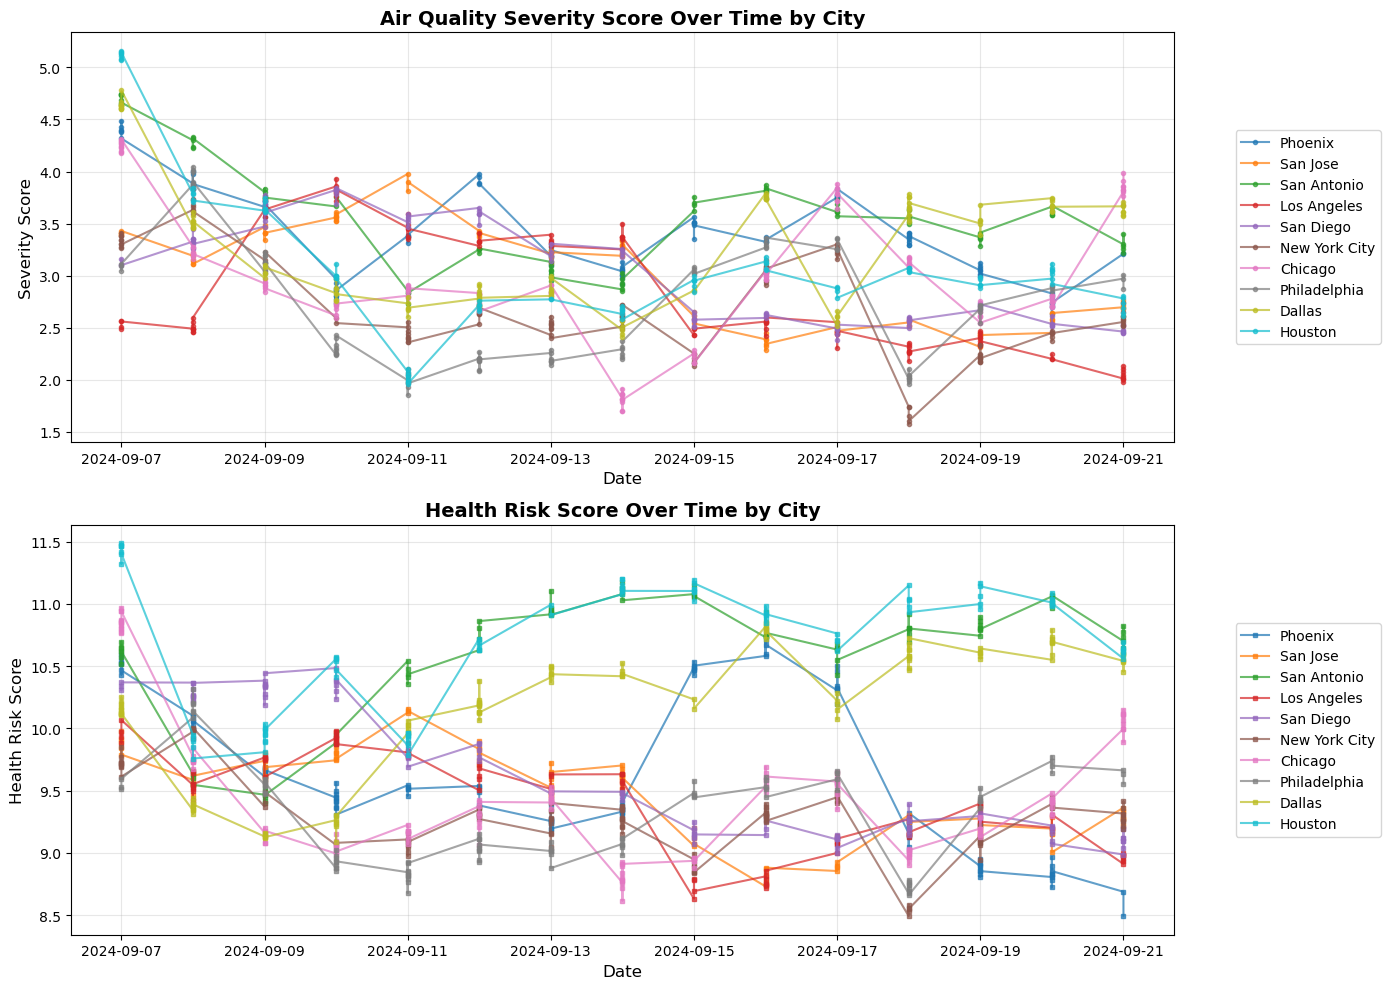

In [7]:
# Time series plot: Severity Score over time by city
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Severity Score over time
for city in air_quality_df['City'].unique():
    city_data = air_quality_df[air_quality_df['City'] == city].sort_values('datetime')
    axes[0].plot(city_data['datetime'], city_data['Severity_Score'], 
                 label=city, marker='o', markersize=3, alpha=0.7)

axes[0].set_title('Air Quality Severity Score Over Time by City', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Severity Score', fontsize=12)
axes[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[0].grid(True, alpha=0.3)

# Plot 2: Health Risk Score over time
for city in air_quality_df['City'].unique():
    city_data = air_quality_df[air_quality_df['City'] == city].sort_values('datetime')
    axes[1].plot(city_data['datetime'], city_data['Health_Risk_Score'], 
                 label=city, marker='s', markersize=3, alpha=0.7)

axes[1].set_title('Health Risk Score Over Time by City', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Health Risk Score', fontsize=12)
axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Visualization 3: Geographic Comparison - City Comparison

**Purpose**: Compare average air quality metrics across different cities

**Chart Type**: Box plots

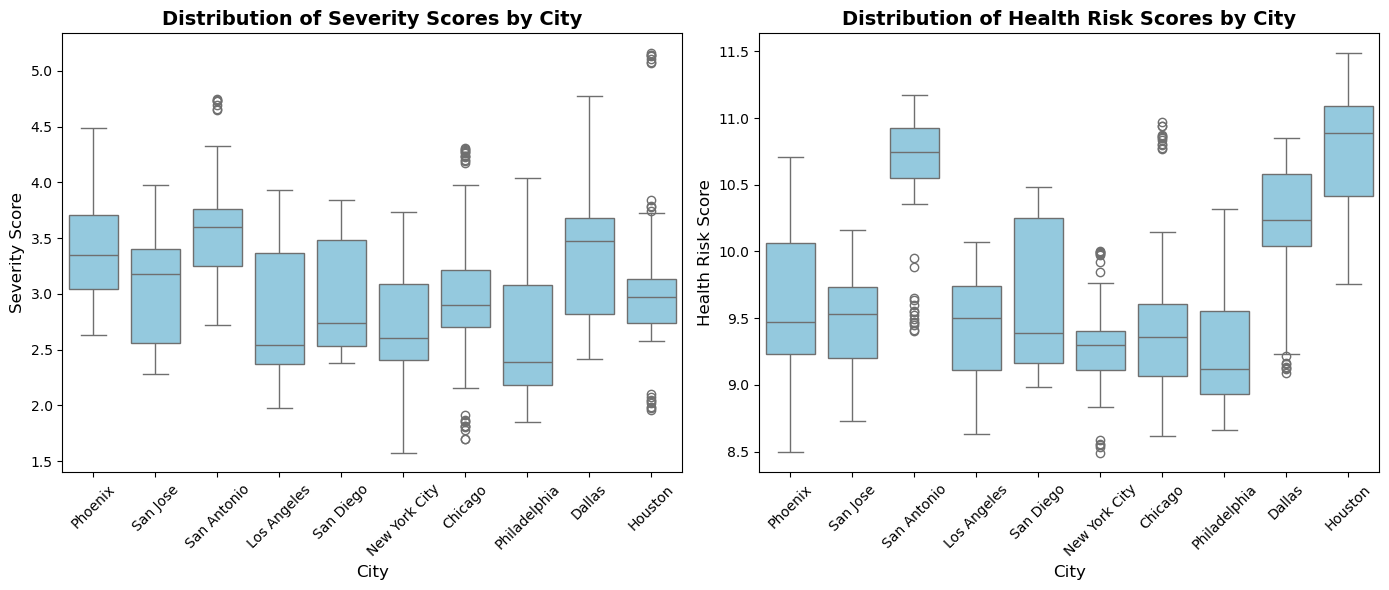

In [8]:
# City comparison: Box plots showing distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for Severity Score by city
sns.boxplot(data=air_quality_df, x='City', y='Severity_Score', color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Severity Scores by City', fontsize=14, fontweight='bold')
axes[0].set_xlabel('City', fontsize=12)
axes[0].set_ylabel('Severity Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Box plot for Health Risk Score by city
sns.boxplot(data=air_quality_df, x='City', y='Health_Risk_Score', color='skyblue', ax=axes[1])
axes[1].set_title('Distribution of Health Risk Scores by City', fontsize=14, fontweight='bold')
axes[1].set_xlabel('City', fontsize=12)
axes[1].set_ylabel('Health Risk Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Visualization 4: Weekend vs Weekday Analysis

**Purpose**: Compare air quality on weekends vs weekdays

**Chart Type**: Box plots

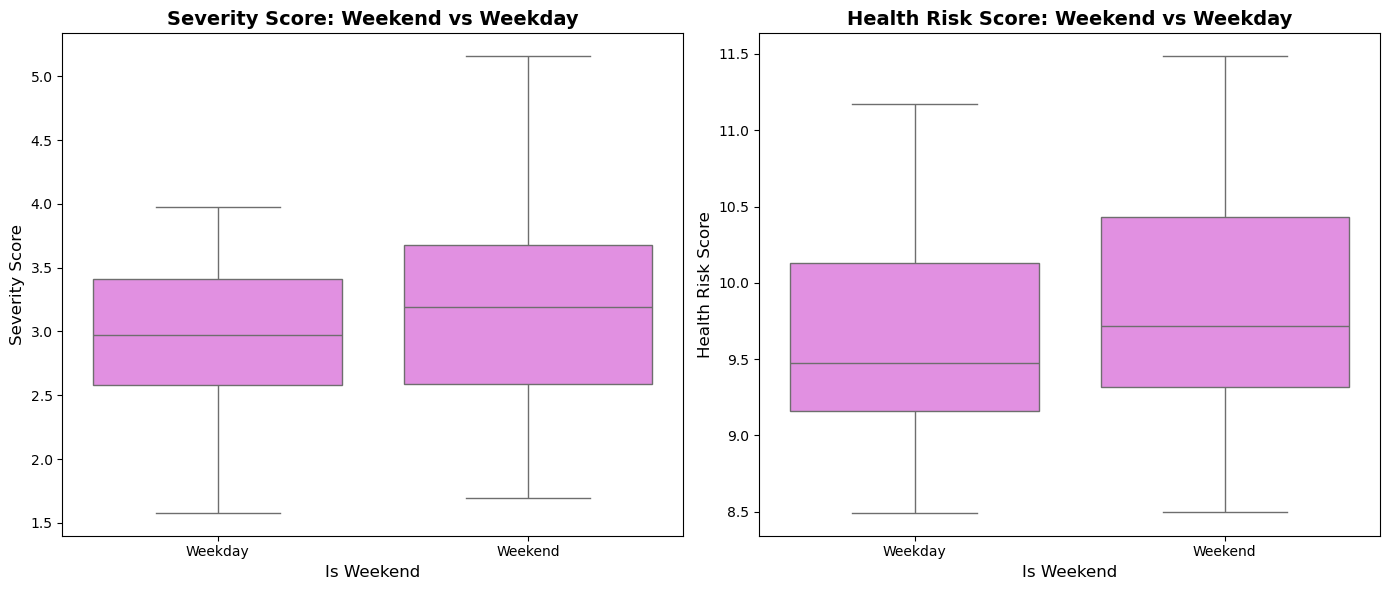

In [9]:
# Weekend vs Weekday comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for Severity Score
sns.boxplot(data=air_quality_df, x='Is_Weekend', y='Severity_Score', color='violet', ax=axes[0])
axes[0].set_title('Severity Score: Weekend vs Weekday', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Is Weekend', fontsize=12)
axes[0].set_ylabel('Severity Score', fontsize=12)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Weekday', 'Weekend'])

# Box plot for Health Risk Score
sns.boxplot(data=air_quality_df, x='Is_Weekend', y='Health_Risk_Score', color='violet', ax=axes[1])
axes[1].set_title('Health Risk Score: Weekend vs Weekday', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Is Weekend', fontsize=12)
axes[1].set_ylabel('Health Risk Score', fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Weekday', 'Weekend'])

plt.tight_layout()
plt.show()


## Visualization 5: Day of Week Analysis

**Purpose**: Compare air quality on each day of the week

**Chart Type**: Heatmap based on average scores for each day

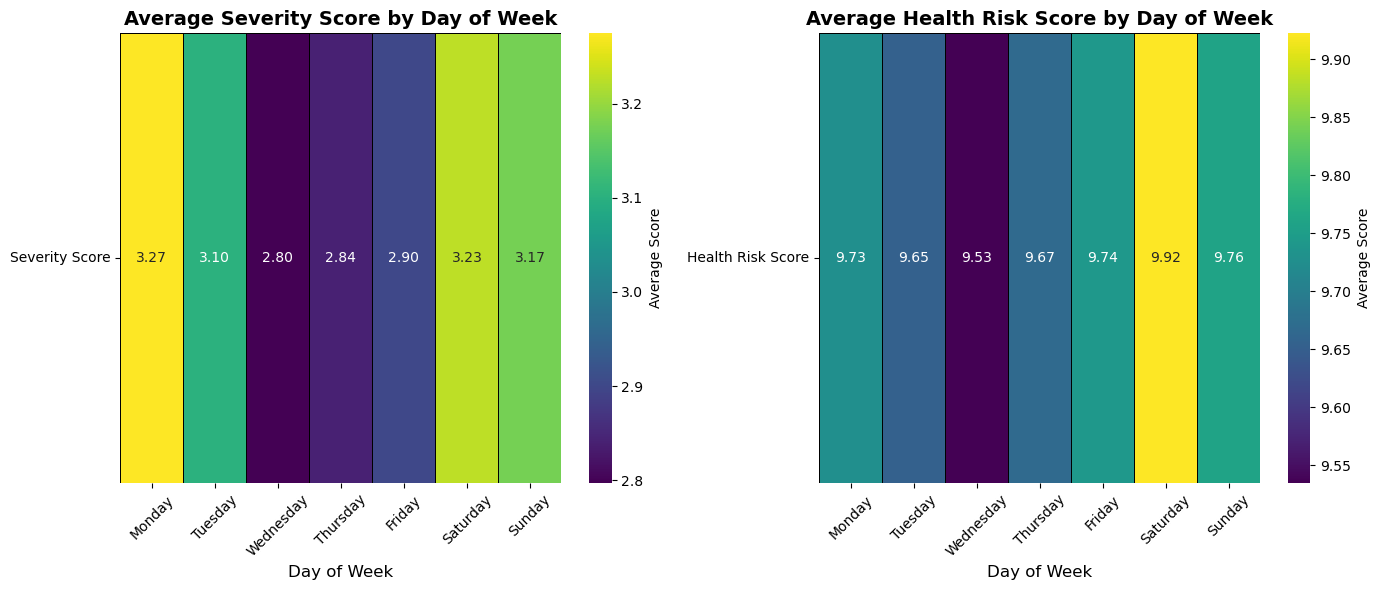

In [10]:
# Day of week analysis - Heatmap
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
air_quality_df['Day_of_Week'] = pd.Categorical(air_quality_df['Day_of_Week'], categories=day_order, ordered=True)

# Create pivot table with average scores by day of week
day_stats = air_quality_df.groupby('Day_of_Week', observed=True)[['Severity_Score', 'Health_Risk_Score']].mean()

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap for Severity Score
sns.heatmap(day_stats[['Severity_Score']].T, 
            annot=True, 
            fmt='.2f', 
            cmap='viridis',
            cbar_kws={'label': 'Average Score'},
            ax=axes[0],
            linewidths=0.5,
            linecolor='black')
axes[0].set_title('Average Severity Score by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week', fontsize=12)
axes[0].set_ylabel('')
axes[0].set_yticklabels(['Severity Score'], rotation=0)
axes[0].tick_params(axis='x', rotation=45)

# Heatmap for Health Risk Score
sns.heatmap(day_stats[['Health_Risk_Score']].T, 
            annot=True, 
            fmt='.2f', 
            cmap='viridis',
            cbar_kws={'label': 'Average Score'},
            ax=axes[1],
            linewidths=0.5,
            linecolor='black')
axes[1].set_title('Average Health Risk Score by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_yticklabels(['Health Risk Score'], rotation=0)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Visualization 6: Correlation Analysis

**Purpose**: Understand relationship between Severity Score and Health Risk Score

**Chart Type**: Scatter plot

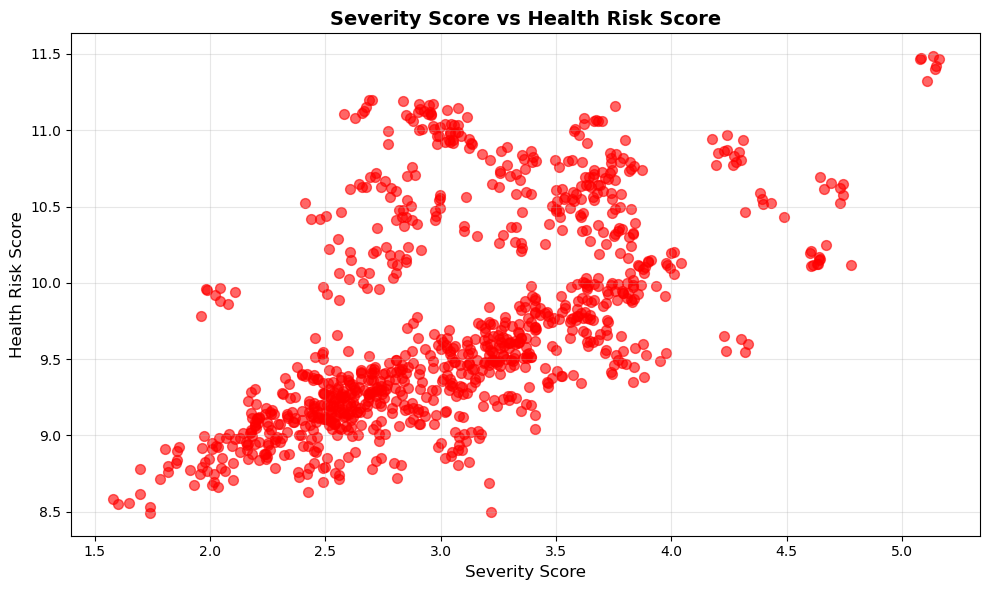

In [11]:
# Correlation analysis
# Scatter plot: Severity Score vs Health Risk Score
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(air_quality_df['Severity_Score'], air_quality_df['Health_Risk_Score'], 
                    c='red', alpha=0.6, s=50)
ax.set_xlabel('Severity Score', fontsize=12)
ax.set_ylabel('Health Risk Score', fontsize=12)
ax.set_title('Severity Score vs Health Risk Score', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 7: Distribution Analysis

**Purpose**: Understand the distribution of air quality metrics

**Chart Type**: Histograms, KDE

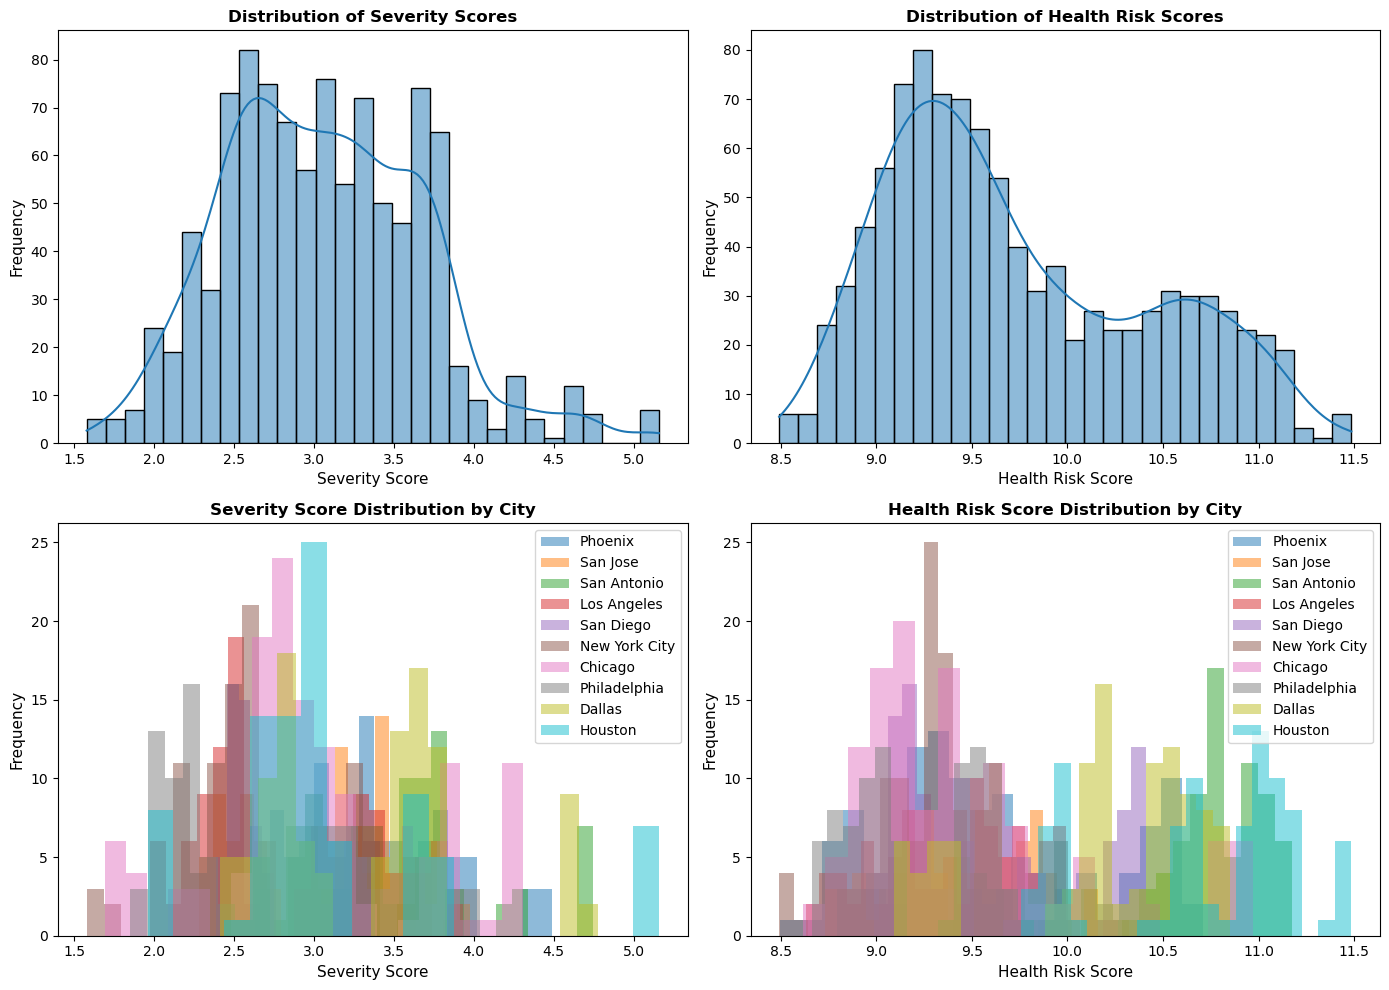

In [12]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram with KDE for Severity Score
sns.histplot(data=air_quality_df, x='Severity_Score', kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Severity Scores', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Severity Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)

# Histogram with KDE for Health Risk Score
sns.histplot(data=air_quality_df, x='Health_Risk_Score', kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Health Risk Scores', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Health Risk Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)

# Distribution by city - Severity Score
for city in air_quality_df['City'].unique():
    city_data = air_quality_df[air_quality_df['City'] == city]['Severity_Score']
    axes[1, 0].hist(city_data, alpha=0.5, label=city, bins=20)
axes[1, 0].set_title('Severity Score Distribution by City', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Severity Score', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].legend()

# Distribution by city - Health Risk Score
for city in air_quality_df['City'].unique():
    city_data = air_quality_df[air_quality_df['City'] == city]['Health_Risk_Score']
    axes[1, 1].hist(city_data, alpha=0.5, label=city, bins=20)
axes[1, 1].set_title('Health Risk Score Distribution by City', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Health Risk Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## Visualization 8: Condition Classification

**Purpose**: Understanding the occurrence of certain conditions, cloudy(-1.0) vs. clear(0.0), and how it could potentially correlate to air quality

**Chart Type**: Bar Chart

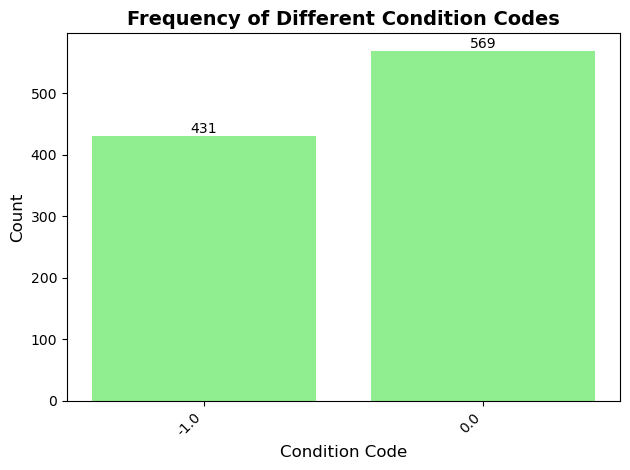

In [13]:
# Condition Classification
condition_counts = (
    air_quality_df['Condition_Code']
      .value_counts(dropna=False)
      .sort_index()
)
condition_counts.index = condition_counts.index.map(lambda val: 'Missing' if pd.isna(val) else val)

bars = plt.bar(condition_counts.index.astype(str), condition_counts.values, color='lightgreen')
plt.title('Frequency of Different Condition Codes', fontsize=14, fontweight='bold')
plt.bar_label(bars)
plt.xlabel('Condition Code', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()